In [1]:
import numpy as np
import matplotlib.pyplot as plt

# For synthesis, we'll use mir_eval's sonify module
import mir_eval.sonify

# For audio playback, we'll use IPython.display's Audio widget
from IPython.display import Audio

import librosa

In [2]:
y, sr = librosa.load("audio/wav/Bombus_Lucorum [dfVM-uvxBqY]-02.wav")

Audio(y, rate=sr)

In [3]:
f0, voicing, voicing_probability = librosa.pyin(y=y, sr=sr, fmin=50, fmax=300)

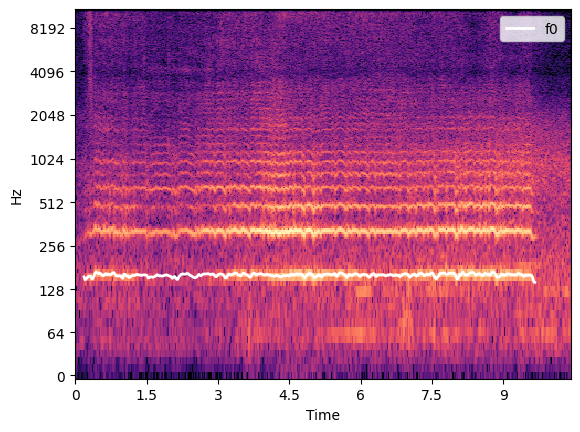

In [5]:
S = np.abs(librosa.stft(y))

times = librosa.times_like(S, sr=sr)

fig, ax = plt.subplots()
librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),
                         y_axis='log', x_axis='time', ax=ax)
ax.plot(times, f0, linewidth=2, color='white', label='f0')
ax.legend()
plt.show()

In [16]:
print(f0)

[         nan          nan          nan          nan          nan
          nan          nan          nan 156.0130452  148.96774631
 151.57165665 154.22108254 157.82582947 157.82582947 157.82582947
 150.69866815 152.44970233 157.82582947 166.24757923 168.17928305
 166.24757923 164.33806292 166.24757923 164.33806292 160.58457637
 158.7401052  159.65967727 163.39154532 164.33806292 161.51483336
 163.39154532 162.45047927 161.51483336 163.39154532 166.24757923
 167.21064166 162.45047927 158.7401052  158.7401052  157.82582947
 158.7401052  158.7401052  155.11447618 152.44970233 162.45047927
 162.45047927 159.65967727 157.82582947 158.7401052  154.22108254
 156.0130452  158.7401052  159.65967727 159.65967727 159.65967727
 161.51483336 162.45047927 161.51483336 160.58457637 160.58457637
 159.65967727 160.58457637 161.51483336 160.58457637 160.58457637
 159.65967727 153.33283447 154.22108254 156.0130452  156.0130452
 155.11447618 156.0130452  156.91681958 158.7401052  161.51483336
 160.584576

In [8]:
# Let's use the first 30 harmonics: 1, 2, 3, ..., 30
harmonics = np.arange(1, 11)

# And standard Fourier transform frequencies
frequencies = librosa.fft_frequencies(sr=sr)

harmonic_energy = librosa.f0_harmonics(S, f0=f0, harmonics=harmonics, freqs=frequencies)

In [15]:
print(harmonic_energy.shape)

(10, 449)


[Text(0, 0.5, 'Harmonics')]

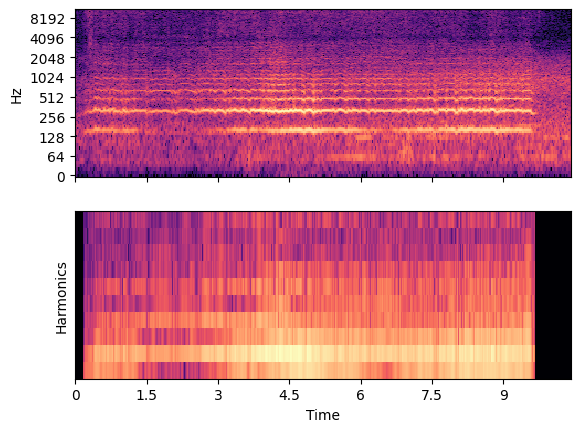

In [9]:
# sphinx_gallery_thumbnail_number = 2

fig, ax = plt.subplots(nrows=2, sharex=True)

librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),
                         y_axis='log', x_axis='time', ax=ax[0])
librosa.display.specshow(librosa.amplitude_to_db(harmonic_energy, ref=np.max),
                         x_axis='time', ax=ax[1])
ax[0].label_outer()
ax[1].set(ylabel='Harmonics')

In [10]:
# f0 takes value np.nan for unvoiced regions, but this isn't
# helpful for synthesis.  We'll use `np.nan_to_num` to replace
# nans with a frequency of 0.
f0_synth = np.nan_to_num(f0)

y_out = np.zeros_like(y)

for i, (factor, energy) in enumerate(zip(harmonics, harmonic_energy)):
    # Mix in a synthesized pitch contour
    y_out = y_out + mir_eval.sonify.pitch_contour(times, f0_synth * factor,
                                                amplitudes=energy,
                                                fs=sr,
                                                length=len(y))

Audio(data=y_out, rate=sr)

In [11]:
# Make a fake f0 contour
f_mono = 110 * np.ones_like(f0)

ymono = np.zeros_like(y)

for i, (factor, energy) in enumerate(zip(harmonics, harmonic_energy)):
    # Use f_mono here instead of f0
    ymono = ymono + mir_eval.sonify.pitch_contour(times, f_mono * factor,
                                                amplitudes=energy,
                                                fs=sr,
                                                length=len(y))

Audio(data=ymono, rate=sr)